Bubble Identification Based on Filaments

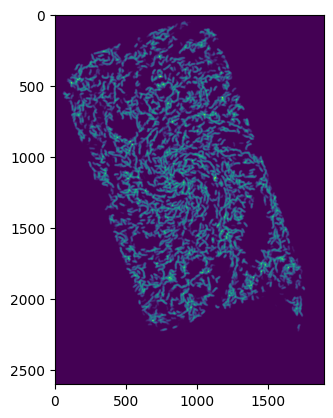

In [8]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import cv2
from skimage.measure import label, regionprops
from scipy.ndimage import gaussian_filter, zoom
import matplotlib.pyplot as plt

def identify_bubbles(image_path, min_area, max_area, output_text, output_fits):
    """
    Identifies bubbles in a filament image and outputs a catalog and FITS file with ellipses.

    Parameters:
    image_path (str): Path to the filament image (FITS file).
    min_area (int): Minimum area of elliptical gaps in pixels.
    max_area (int): Maximum area of elliptical gaps in pixels.
    output_text (str): Path to output bubble catalog text file.
    output_fits (str): Path to output FITS file with ellipses drawn.

    Returns:
    None
    """
    # Load the filament image and WCS header
    with fits.open(image_path) as hdul:
        image_data = hdul[0].data
        wcs = WCS(hdul[0].header)

    # Normalize the image data for thresholding
    image = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
    image = (image * 255).astype(np.uint8)

    
    # Calculate sigma for Gaussian convolution
    sigma = 4


    # Apply Gaussian blur
    image = gaussian_filter(image, sigma=sigma)

    plt.imshow(image)
    plt.show()
    
    # Threshold the image to identify blank regions
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Label connected components
    labeled = label(binary, connectivity=2)

    # Prepare catalog
    catalog = []

    # Create a blank image to draw ellipses
    fits_image = np.zeros_like(image, dtype=np.uint8)

    # Iterate through regions and fit ellipses
    for region in regionprops(labeled):
        if min_area <= region.area <= max_area:
            # Fit ellipse
            y, x = region.centroid
            major_axis = region.major_axis_length / 2
            minor_axis = region.minor_axis_length / 2
            orientation = np.degrees(region.orientation)  # Correct orientation

            # Convert pixel coordinates to RA/Dec using WCS
            ra, dec = wcs.wcs_pix2world([[x, y]], 0)[0]

            # Compute bubble parameters
            avg_radius = (major_axis + minor_axis) / 2
            gal_rad_kpc = np.nan  # Placeholder for galactocentric distance
            dist_arm_pc = np.nan  # Placeholder for distance to arm

            catalog.append([
                len(catalog) + 1,
                ra, dec,
                major_axis, minor_axis, avg_radius,
                orientation, "", dist_arm_pc, gal_rad_kpc
            ])

            # Draw the ellipse on the FITS image
            center = (int(x), int(y))
            axes = (int(major_axis), int(minor_axis))
            cv2.ellipse(fits_image, center, axes, orientation, 0, 360, 255, 1)

    # Save catalog as a text file
    df = pd.DataFrame(catalog, columns=[
        "ID", "RA_DMS", "DEC_DMS", "SEMI_MAJ_PC", "SEMI_MIN_PC", "AVG_RAD_PC",
        "PA_DEG", "ARM", "DIST_ARM_PC", "GAL_RAD_KPC"
    ])
    df.to_csv(output_text, index=False, sep='\t')

    # Save the FITS file
    hdu = fits.PrimaryHDU(fits_image, header=wcs.to_header())
    hdu.writeto(output_fits, overwrite=True)


# Example usage
image_path = r"C:\Users\HP\Documents\Research\FilPHANGS\ngc0628\Composites\ngc0628_JWST_F770W_starsub_CDDss0016pc_CompositeBlur.fits"
min_area_pixels = (3.1415 * 6**2) / (5.24**2)
max_area_pixels = (3.1415 * 500**2) / (5.24**2)
output_text_path = r"C:\Users\HP\Documents\Research\FilPHANGS\ngc0628\Bubbles\Bubbles.txt"
output_fits_path = r"C:\Users\HP\Documents\Research\FilPHANGS\ngc0628\Bubbles\Bubbles.fits"

identify_bubbles(image_path, min_area_pixels, max_area_pixels, output_text_path, output_fits_path)


In [15]:
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u


def convert_bubble_catalog(input_file, output_file):
    """
    Converts a bubble catalog from DMS format to decimal degrees and computes additional fields.

    Parameters:
    input_file (str): Path to the input text file in the original format.
    output_file (str): Path to save the output text file in the new format.

    Returns:
    None
    """
    # Load the input file
    column_names = [
        "ID", "RA_DMS", "DEC_DMS", "SEMI_MAJ_PC", "SEMI_MIN_PC",
        "AVG_RAD_PC", "PA_DEG", "ARM", "DIST_ARM_PC", "GAL_RAD_KPC"
    ]
    data = pd.read_csv(input_file, sep=',', names=column_names, skiprows=1)

    # Convert RA and DEC from DMS to decimal degrees
    coords = SkyCoord(data['RA_DMS'], data['DEC_DMS'], unit=(u.deg, u.deg))
    data['RA_DEC_DEG'] = coords.ra.deg
    data['DEC_DEG'] = coords.dec.deg

    # Save the new format
    data.to_csv(output_file, sep='\t', index=False)
    print(f"Converted catalog saved to {output_file}")


def compare_bubble_catalogs(file1, file2, tolerance_arcsec):
    """
    Compare two bubble catalogs based only on spatial coordinates and print the number of bubbles 
    that match (within the given tolerance) in the smaller file.

    Parameters:
    file1 (str): Path to the first bubble catalog text file.
    file2 (str): Path to the second bubble catalog text file.
    tolerance_arcsec (float): Tolerance in arcseconds for matching bubbles.

    Returns:
    None
    """
    # Load the bubble catalogs
    catalog1 = pd.read_csv(file1, sep='\t')
    catalog2 = pd.read_csv(file2, sep='\t')

    # Convert RA and Dec to SkyCoord objects
    coords1 = SkyCoord(catalog1['RA_DMS'], catalog1['DEC_DMS'], unit=(u.deg, u.deg))
    coords2 = SkyCoord(catalog2['RA_DMS'], catalog2['DEC_DMS'], unit=(u.deg, u.deg))

    # Initialize matched count
    matched = 0

    # Loop through each coordinate in catalog1 and find matches in catalog2
    for coord1 in coords1:
        # Compute separation between coord1 and all points in coords2
        separations = coord1.separation(coords2).arcsecond
        
        # Check if there's any separation less than or equal to the tolerance
        if any(separations <= tolerance_arcsec):
            matched += 1

    # Determine the smaller catalog size
    smaller_catalog_size = min(len(catalog1), len(catalog2))

    # Print results
    print(f"Matched bubbles: {matched} out of {smaller_catalog_size} bubbles in the smaller file.")

# Example usage
file1 = r"C:\Users\HP\Documents\Research\FilPHANGS\ngc0628\Bubbles\jwst_bubble_properties_A.txt"
file2 = r"C:\Users\HP\Documents\Research\FilPHANGS\ngc0628\Bubbles\Bubbles.txt"
tolerance_arcsec = 10  # Tolerance in arcseconds

convert_bubble_catalog(file1, file1) #correct format 

compare_bubble_catalogs(file1, file2, tolerance_arcsec)


Converted catalog saved to C:\Users\HP\Documents\Research\FilPHANGS\ngc0628\Bubbles\jwst_bubble_properties_A.txt
Matched bubbles: 0 out of 61 bubbles in the smaller file.
